Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../../src")

import anoog

Data Loading

In [3]:
train_df, test_df = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.TSFRESH,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=True,
                        test_size=0.3)

X_train, y_train = train_df.drop(columns=['y']), train_df.y
X_test, y_test = test_df.drop(columns=['y']), test_df.y

C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['Audio__query_similarity_count__query_None__threshold_0.0'
 'Voltage__query_similarity_count__query_None__threshold_0.0'
 'Current__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


Model Training

In [4]:
model = anoog.model.train_random_forest(X_train, y_train)

In [5]:
model.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [6]:
len(model.estimators_)

100

Plot all Decision Trees

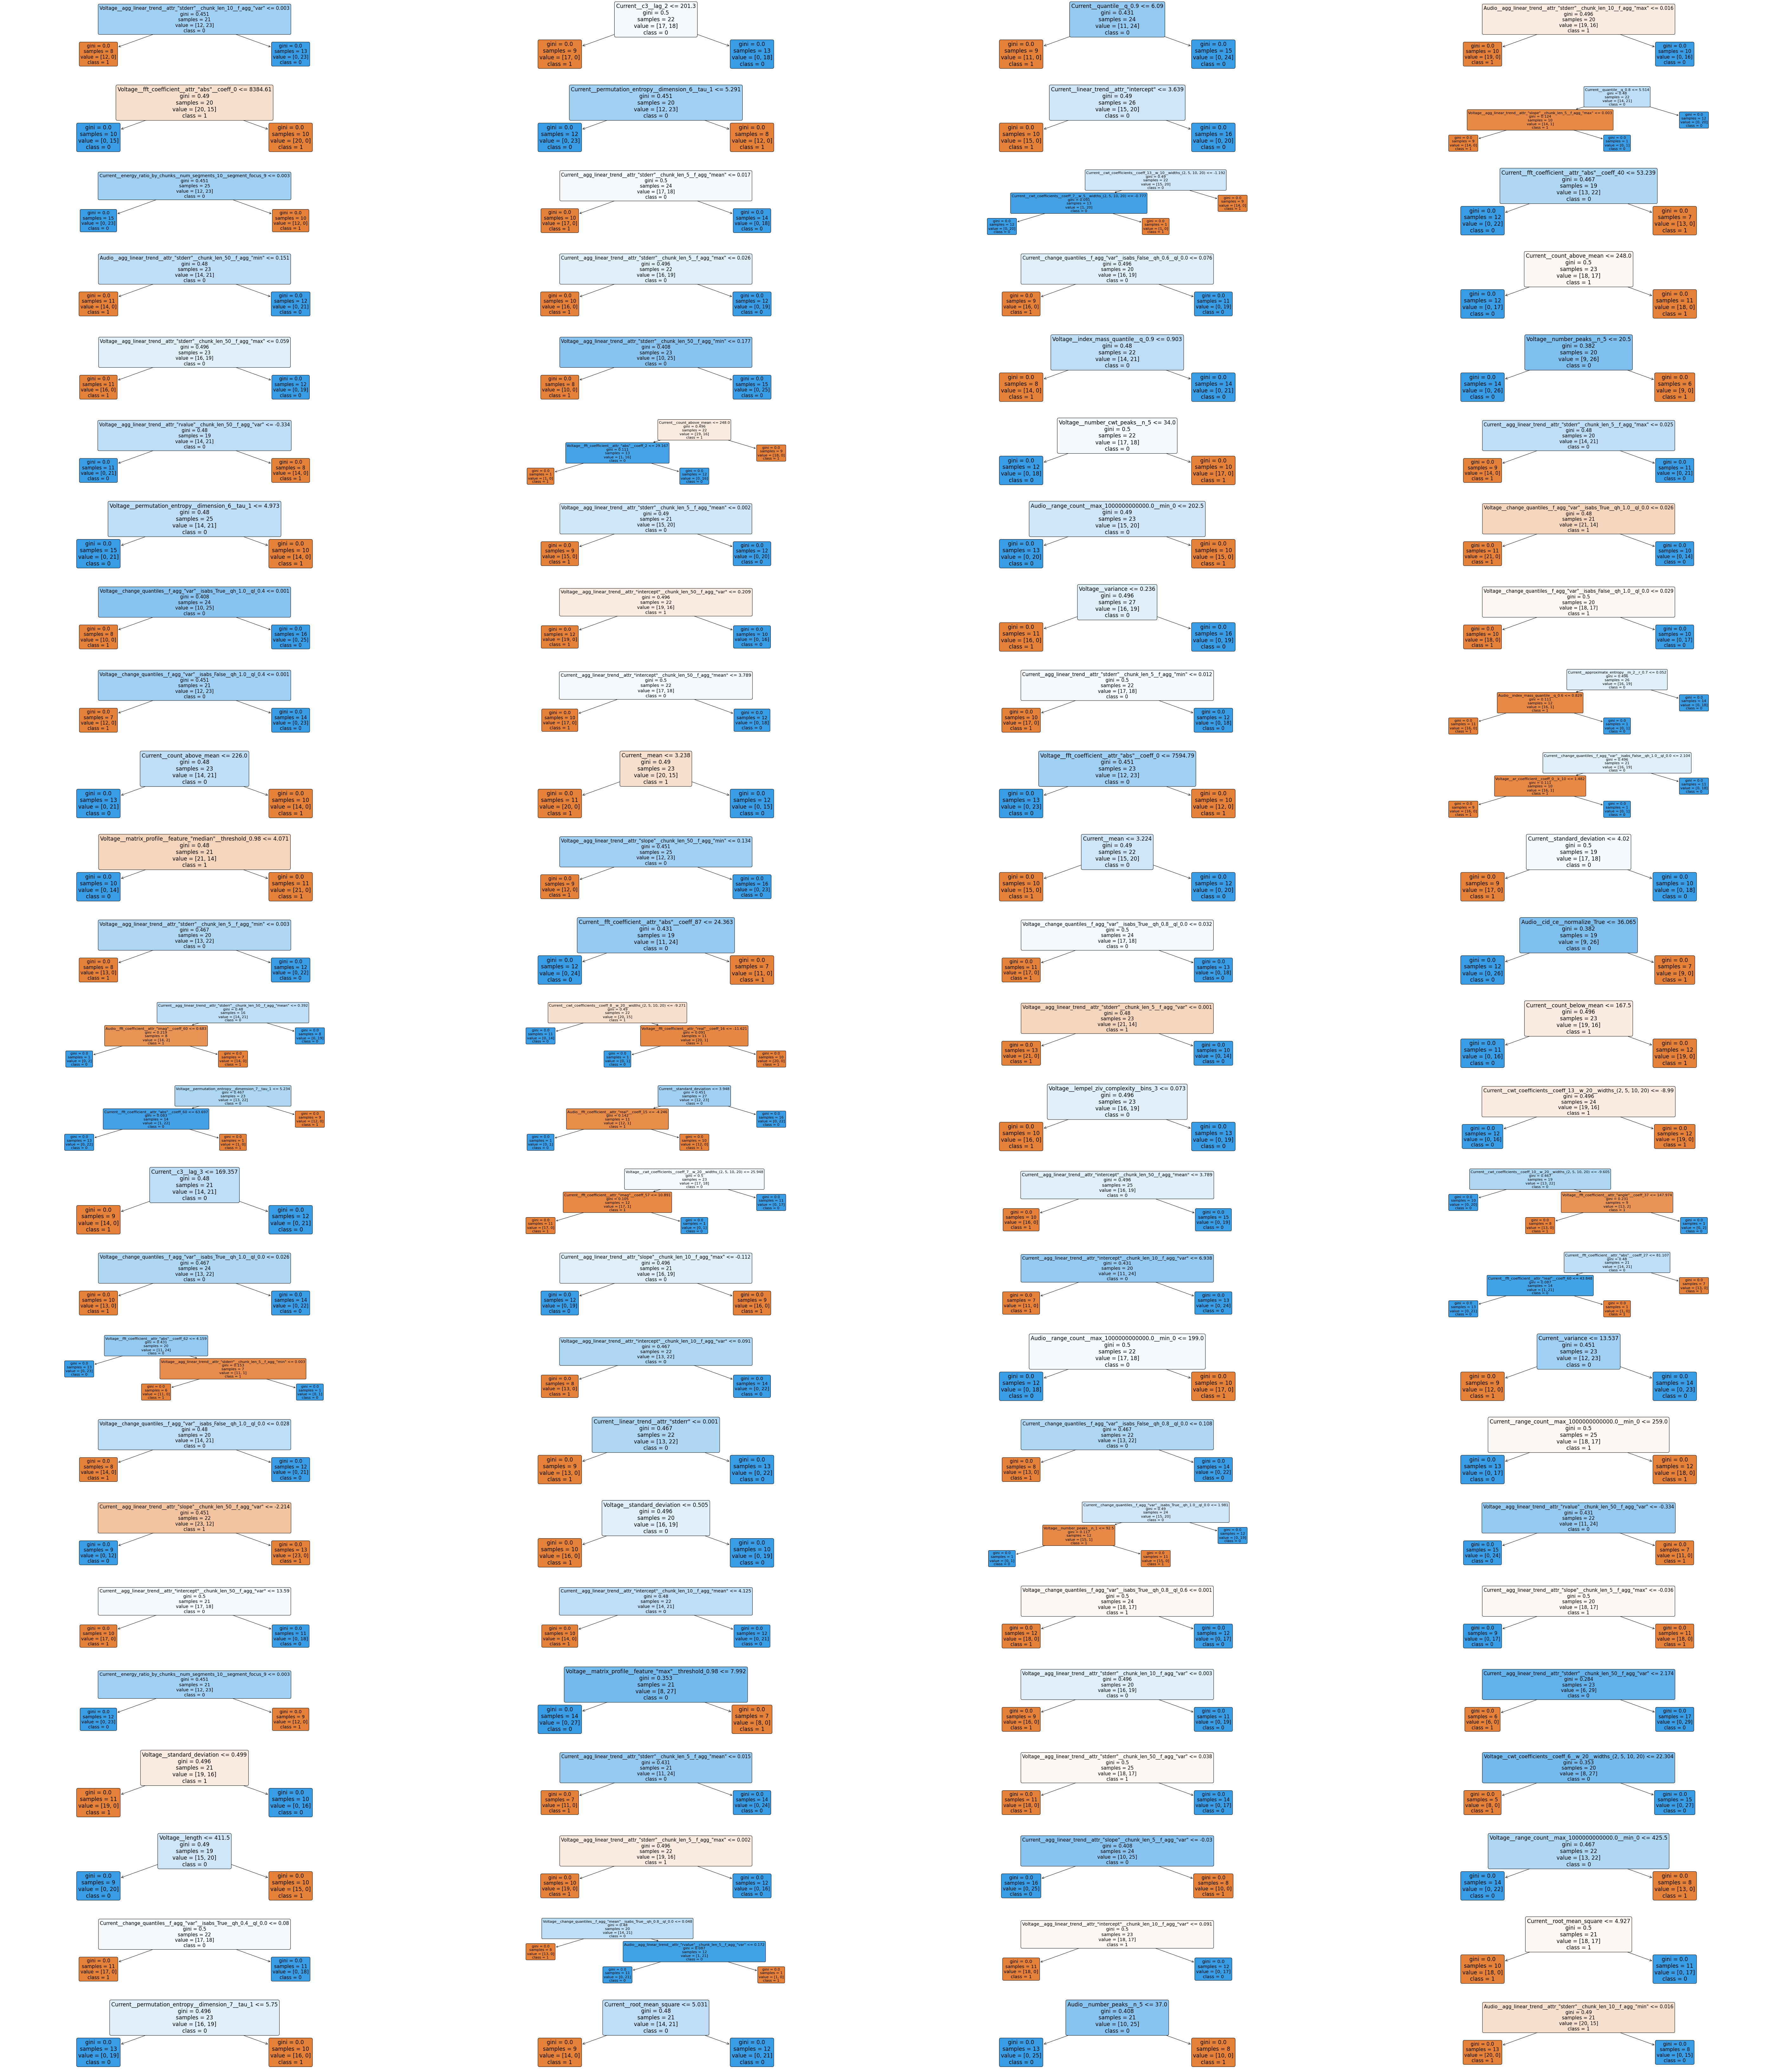

In [7]:
from sklearn.tree import plot_tree

# in MATLAB style
fig, ax = plt.subplots(25, 4, figsize=(100, 120))

row = 0
col = 0

for estimator in model.estimators_:

    plot_tree(estimator,
                feature_names = X_train.columns, 
                class_names=y_train.unique().astype(str),
                filled = True,
                rounded=True,
                ax=ax[row, col])
                #proportion=False)
    #ax[row, col] = plt.show()

    if col >= 3:
        col = 0
        row += 1
    else:
        col += 1


Wichtigster erster Split

In [8]:
def get_most_important_features(X=X_train, n=5):
    importance_list = np.hstack((X_train.columns.to_numpy().reshape(-1, 1), model.feature_importances_.reshape(-1, 1)))
    sorted_feature_importance = importance_list[importance_list[:, 1].argsort()][::-1, :] 
    for i in range(n):
        print(f"{i+1}. {sorted_feature_importance[i, 0]} ({sorted_feature_importance[i, 1]})")


def get_most_important_features_as_list(X=X_train, n=5):
    importance_list = np.hstack((X_train.columns.to_numpy().reshape(-1, 1), model.feature_importances_.reshape(-1, 1)))
    sorted_feature_importance = importance_list[importance_list[:, 1].argsort()][::-1, :] 
    result = []
    for i in range(n):
        result += [sorted_feature_importance[i, 0]]
    return result

In [9]:
get_most_important_features(X_train, n=10)

1. Current__count_above_mean (0.028916408668730655)
2. Current__root_mean_square (0.020000000000000004)
3. Current__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean" (0.020000000000000004)
4. Current__energy_ratio_by_chunks__num_segments_10__segment_focus_9 (0.020000000000000004)
5. Current__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" (0.020000000000000004)
6. Current__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean" (0.020000000000000004)
7. Voltage__standard_deviation (0.020000000000000004)
8. Voltage__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var" (0.020000000000000004)
9. Voltage__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0 (0.020000000000000004)
10. Voltage__fft_coefficient__attr_"abs"__coeff_0 (0.020000000000000004)


In [10]:
get_most_important_features_as_list(X_train, n=10)

['Current__count_above_mean',
 'Current__root_mean_square',
 'Current__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
 'Current__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
 'Current__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
 'Current__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"',
 'Voltage__standard_deviation',
 'Voltage__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var"',
 'Voltage__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0',
 'Voltage__fft_coefficient__attr_"abs"__coeff_0']

Selektion der wichtigsten 20

In [14]:
selected_X_train = X_train.loc[:, get_most_important_features_as_list(X_train, n=20)]
selected_X_test = X_test.loc[:, get_most_important_features_as_list(X_train, n=20)]

In [15]:
selected_model = anoog.model.train_random_forest(selected_X_train, y_train)

In [16]:
acc, con = anoog.model.evaluate_model(selected_model, selected_X_test, y_test)
print(acc)
con

100.0


array([[10,  0],
       [ 0,  5]], dtype=int64)

Decision Tree

In [17]:
model_2 = anoog.model.train_decision_tree(X_train, y_train)
#acc, con = anoog.model.evaluate_model(model_2, X_test, y_test)
#print("Accuracy:", acc)
#con

[Text(558.0, 815.4000000000001, 'Voltage__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"var" <= 0.003\ngini = 0.49\nsamples = 35\nvalue = [15, 20]\nclass = 0'),
 Text(279.0, 271.79999999999995, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]\nclass = 1'),
 Text(837.0, 271.79999999999995, 'gini = 0.0\nsamples = 20\nvalue = [0, 20]\nclass = 0')]

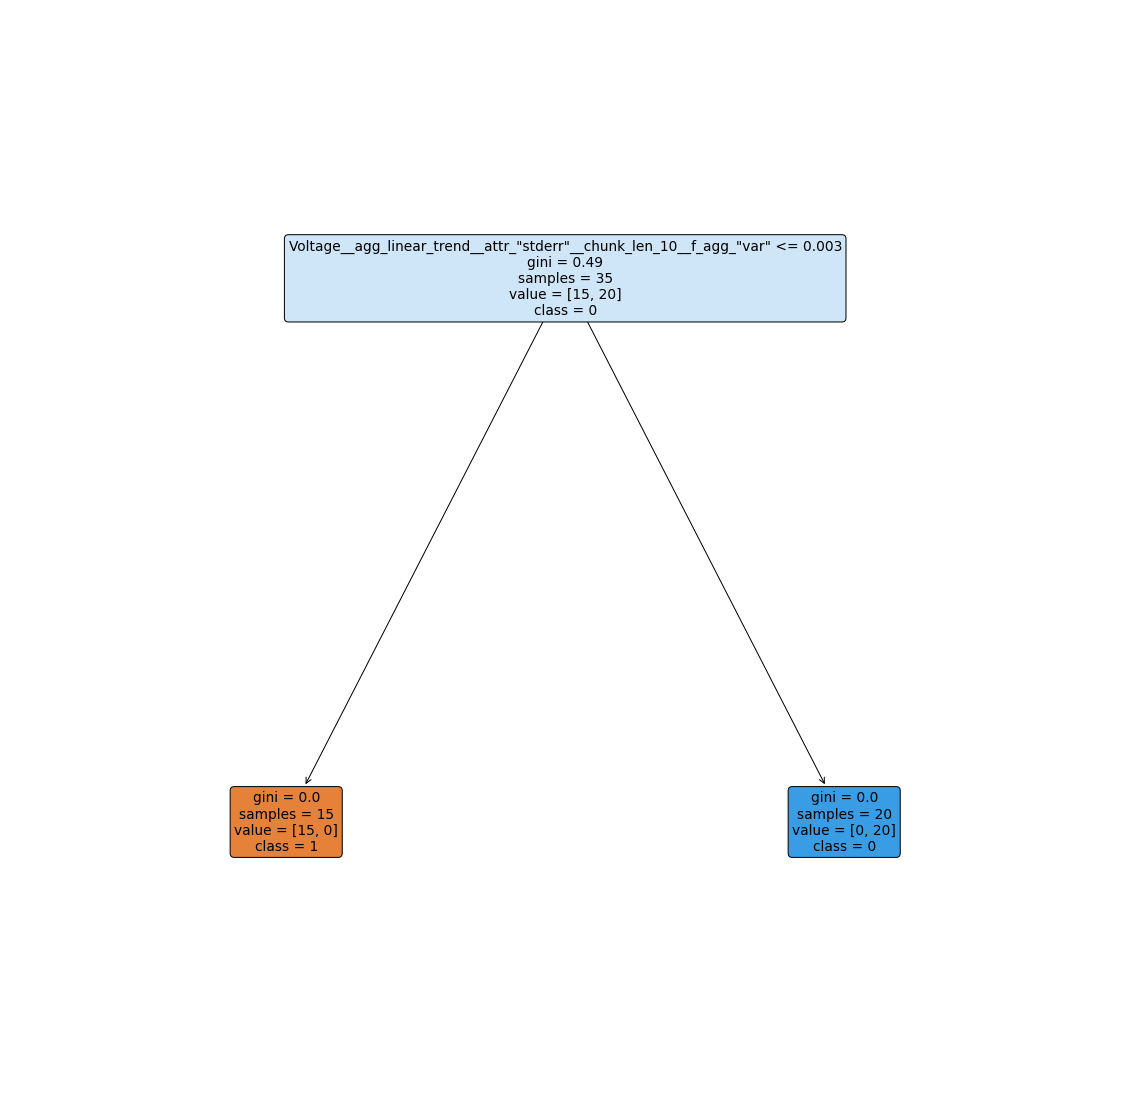

In [18]:
plt.figure(figsize=(20,20))

plot_tree(model_2,
            feature_names = X_train.columns, 
            class_names=y_train.unique().astype(str),
            filled = True,
            rounded=True)

In [20]:
train_data, test_data = anoog.io.load_data("../../data/2021-11-09",
                                            ['vkorzev', 'skadkade'],
                                            extraction=anoog.io.extraction_mode.TSFRESH_WITH_PARAMS,
                                            show_extraction=True,
                                            selection=anoog.io.selection_mode.NONE,
                                            train_test_split=True,
                                            test_size=0.3)
        
X_train, y_train = anoog.io.X_y_split(train_data)
X_test, y_test = anoog.io.X_y_split(test_data)

model = anoog.model.train_random_forest(X_train, y_train)
anoog.model.get_most_important_features(model, X_train, 5)

Feature Extraction: 100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


1. Voltage__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max" (0.04)
2. Voltage__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var" (0.04)
3. Voltage__standard_deviation (0.03)
4. Voltage__variance (0.03)
5. Voltage__fft_coefficient__attr_"real"__coeff_0 (0.03)


Experimente mit den wichtigsten Features nach RandomForrest

In [3]:
# init
# model for the importance of features
train_data, test_data = anoog.io.load_data("../../data/2021-11-09",
                                            ['vkorzev', 'skadkade'],
                                            extraction=anoog.io.extraction_mode.TSFRESH_WITH_PARAMS,
                                            show_extraction=False,
                                            selection=anoog.io.selection_mode.NONE,
                                            train_test_split=True,
                                            test_size=0.3)
        
X_train, y_train = anoog.io.X_y_split(train_data)
X_test, y_test = anoog.io.X_y_split(test_data)

model_refernce = anoog.model.train_random_forest(X_train, y_train)

# start experiment entry
entries = []
entry_id = 0
test_size = 0.3
extraction_method = anoog.io.extraction_mode.TSFRESH_WITH_PARAMS
selection_method = anoog.io.selection_mode.NONE

# start experiment
for persons in [['tippolit', 'vkorzev'], ['vkorzev', 'skadkade'], ['tippolit', 'skadkade']]:
    for n in np.arange(1, 5):
        cur_entry = f"--------\n--------\nVersuch {entry_id}:\n    - Persons = {persons}"
        cur_entry += f"\n    - Extraction-Method = {extraction_method}"
        cur_entry += f"\n    - Selection-Method = {selection_method}"
        cur_entry += f"\n    - Number of Selections = {n}"
        entry_id += 1
        train_data, test_data = anoog.io.load_data("../../data/2021-11-09",
                                                    persons,
                                                    extraction=extraction_method,
                                                    show_extraction=False,
                                                    selection=selection_method,
                                                    train_test_split=True,
                                                    test_size=test_size)
        
        X_train, y_train = anoog.io.X_y_split(train_data)
        X_test, y_test = anoog.io.X_y_split(test_data)

        selected_X_train = X_train.loc[:, anoog.model.get_most_important_features_as_list(model_refernce, X_train, n=n)]
        selected_X_test = X_test.loc[:, anoog.model.get_most_important_features_as_list(model_refernce, X_test, n=n)]
        
        model = anoog.model.train_random_forest(selected_X_train, y_train)
        acc, con = anoog.model.evaluate_model(model, selected_X_test, y_test)

        cur_entry += f"\n    - Selected Features = {anoog.model.get_most_important_features_as_list(model_refernce, X_train, n=n)}"
        cur_entry += f"\n    - Accuracy = {acc}"
        cur_entry += f"\n    - Test-Size = {test_size}"
        cur_entry += f"\n    - Python-Version = {sys.version.split(' ')[0]}"

        entries += [cur_entry]


In [ ]:
txt = ""
for entry in entries:
    txt += f"{entry}\n\n"

print(txt)

--------
Versuch 0:
    - Persons = ['tippolit', 'vkorzev']
    - Extraction-Method = extraction_mode.TSFRESH_WITH_PARAMS
    - Selection-Method = selection_mode.NONE
    - Number of Selections = 1
    - Selected Features = ['Current__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"']
    - Accuracy = 100.0
    - Test-Size = 0.3
    - Python-Version = 3.9.7

--------
Versuch 1:
    - Persons = ['tippolit', 'vkorzev']
    - Extraction-Method = extraction_mode.TSFRESH_WITH_PARAMS
    - Selection-Method = selection_mode.NONE
    - Number of Selections = 2
    - Selected Features = ['Current__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"', 'Voltage__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"']
    - Accuracy = 100.0
    - Test-Size = 0.3
    - Python-Version = 3.9.7

--------
Versuch 2:
    - Persons = ['tippolit', 'vkorzev']
    - Extraction-Method = extraction_mode.TSFRESH_WITH_PARAMS
    - Selection-Method = selection_mode.NONE
    - Number of S

In [ ]:
with open("experiment_random_forest_feature_selection_1.txt", "w") as f:
    f.write(txt)

In [ ]:
# init
# model for the importance of features
train_data, test_data = anoog.io.load_data("../../data/2021-11-09",
                                            ['vkorzev', 'skadkade'],
                                            extraction=anoog.io.extraction_mode.MANUEL,
                                            show_extraction=False,
                                            selection=anoog.io.selection_mode.NONE,
                                            train_test_split=True,
                                            test_size=0.3)
        
X_train, y_train = anoog.io.X_y_split(train_data)
X_test, y_test = anoog.io.X_y_split(test_data)

model_refernce = anoog.model.train_random_forest(X_train, y_train)

# start experiment entry
entries = []
entry_id = 0
test_size = 0.3
extraction_method = anoog.io.extraction_mode.MANUEL
selection_method = anoog.io.selection_mode.NONE

# start experiment
for persons in [['tippolit', 'vkorzev'], ['vkorzev', 'skadkade'], ['tippolit', 'skadkade']]:
    for n in np.arange(1, 5):
        cur_entry = f"--------\n--------\nVersuch {entry_id}:\n    - Persons = {persons}"
        cur_entry += f"\n    - Extraction-Method = {extraction_method}"
        cur_entry += f"\n    - Selection-Method = {selection_method}"
        cur_entry += f"\n    - Number of Selections = {n}"
        entry_id += 1
        train_data, test_data = anoog.io.load_data("../../data/2021-11-09",
                                                    persons,
                                                    extraction=extraction_method,
                                                    show_extraction=False,
                                                    selection=selection_method,
                                                    train_test_split=True,
                                                    test_size=test_size)
        
        X_train, y_train = anoog.io.X_y_split(train_data)
        X_test, y_test = anoog.io.X_y_split(test_data)

        selected_X_train = X_train.loc[:, anoog.model.get_most_important_features_as_list(model_refernce, X_train, n=n)]
        selected_X_test = X_test.loc[:, anoog.model.get_most_important_features_as_list(model_refernce, X_test, n=n)]
        
        model = anoog.model.train_random_forest(selected_X_train, y_train)
        acc, con = anoog.model.evaluate_model(model, selected_X_test, y_test)

        cur_entry += f"\n    - Selected Features = {anoog.model.get_most_important_features_as_list(model_refernce, X_train, n=n)}"
        cur_entry += f"\n    - Accuracy = {acc}"
        cur_entry += f"\n    - Test-Size = {test_size}"
        cur_entry += f"\n    - Python-Version = {sys.version.split(' ')[0]}"

        entries += [cur_entry]


In [ ]:
txt = ""
for entry in entries:
    txt += f"{entry}\n\n"

print(txt)

--------
--------
Versuch 0:
    - Persons = ['tippolit', 'vkorzev']
    - Extraction-Method = extraction_mode.MANUEL
    - Selection-Method = selection_mode.NONE
    - Number of Selections = 1
    - Selected Features = ['voltage_max']
    - Accuracy = 100.0
    - Test-Size = 0.3
    - Python-Version = 3.9.7

--------
--------
Versuch 1:
    - Persons = ['tippolit', 'vkorzev']
    - Extraction-Method = extraction_mode.MANUEL
    - Selection-Method = selection_mode.NONE
    - Number of Selections = 2
    - Selected Features = ['voltage_max', 'voltage_mean']
    - Accuracy = 100.0
    - Test-Size = 0.3
    - Python-Version = 3.9.7

--------
--------
Versuch 2:
    - Persons = ['tippolit', 'vkorzev']
    - Extraction-Method = extraction_mode.MANUEL
    - Selection-Method = selection_mode.NONE
    - Number of Selections = 3
    - Selected Features = ['voltage_max', 'voltage_mean', 'voltage_median']
    - Accuracy = 100.0
    - Test-Size = 0.3
    - Python-Version = 3.9.7

--------
--------

In [ ]:
with open("experiment_random_forest_feature_selection_2.txt", "w") as f:
    f.write(txt)

## Save Audio File

In [ ]:
(data, meta_data) = anoog.io.load_tsfresh('../../data/2021-11-09', ['tippolit', 'vkorzev'])
data.head()

Audio    Voltage   Current                       Time  ID
0 -1.411133  20.420654 -0.866211 2021-11-09 11:50:45.000000   0
1 -1.352539  20.420654 -0.719727 2021-11-09 11:50:45.000014   0
2 -1.289062  20.420654 -0.573242 2021-11-09 11:50:45.000028   0
3 -1.235352  20.420654 -0.792969 2021-11-09 11:50:45.000042   0
4 -1.181641  20.420654 -0.719727 2021-11-09 11:50:45.000056   0

In [ ]:
import wave

for id in data['ID'].unique():
    #print(id)
    #print(data[data['ID'] == id].shape)
    audio_data = data[data['ID'] == id]
    writer = wave.open(f"drill_recording_{id}.wav", "wb")
    writer.setnchannels(65535)
    writer.setsampwidth(1)
    writer.setframerate(44.1)
    writer.writeframes(audio_data.Audio.to_numpy())
    writer.close()
    #with open(f"drill_recording_{id}.wav", "w") as f:
    #    f.write(audio_data.Audio)

In [ ]:
import os

for id in data['ID'].unique():
    while True:
        os.startfile(f"drill_recording_{id}.wav")
        if input(f"Track {id}:") == "exit":
            break

KeyboardInterrupt: Interrupted by user